# Tutorial: GNNs for 2D Particle Tracking

Marcin Wolter
*Jul 2024*

Based (very closely) on:
HEP.TrkX group
Steve Farrell, Daniel Murname

*Feb 2020*

## **What's new?**

In this code we do not do a binary classification anymore, but we would like to classify "edges" as:
* not belonging to any track (none),
* belonging to the positively charged track,
* belonging to the negatively charged track,

so a mechanism like PID (Particle IDentification) is added.

1. Therefore we have to change the data structure, the edge weight (variable *y*) is no longer a scalar but a vector of three numbers denoting the probilities of the edge being a member of  given class (for eample *y=[0.1, 0.9, 0]* means that the edge is most probably a part of positively charged track.

2. The edge network has to have a vector of three numbers as an output:

```
        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 3],
                                        output_activation=None)
```   

3. The loss function can not be `binary_cross_entropy_with_logits()` any longer and has to be replaced by `cross_entropy()`:

        #loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss = F.cross_entropy(pred.float(), data.y.float())
        
 4. In few other places the code has to be modified. I kept the old code as commented lines.       

# Changes 24.07.24

The output activation function is now torch.nn.modules.activation.LogSoftmax . It applies the Log to the softmax output https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html . Unfortunately, the network didn't converge with the softmax function (why???). Now, if we apply np.exp(output) we get the numbers between 0 and 1.

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [2]:
print("PyTorch version:",print(torch.__version__),", CUDA version:", torch.version.cuda)

2.1.0+cu121
PyTorch version: None , CUDA version: 12.1


In [3]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## The Problem

### Toy Data
Please try both max_angle cuts!

In [4]:
# Circle parameters
num_layers = 10
height, width = 10, 10
min_curve, max_curve = 15, 50
noise = False
event_size_min, event_size_max = 4, 12 #I.E. The number of true particle tracks
# Please try both cuts!
#max_angle=(4/6)*np.pi
max_angle=(6/6)*np.pi
feature_scale = np.array([10,10])

In [5]:
# Some dumb circle calculations
def y1(x, r, a, sign):
    return sign*np.sqrt(r**2 - a**2) + np.sqrt(r**2 - (x-a)**2)
def y2(x, r, a, sign):
    return sign*np.sqrt(r**2 - a**2) - np.sqrt(r**2 - (x-a)**2)

# Generate random circle / helix parameters
def rand_pars(event_size_min, event_size_max, max_curve, min_curve):
    event_size = int(np.floor(np.random.random(1)*(event_size_max - event_size_min) + event_size_min))
    radii = np.random.random(event_size)*(max_curve - min_curve) + min_curve
    dirs = np.random.random(event_size)*(radii)*2 -radii
    sign_options = np.array([-1,1])
    signs = sign_options[np.rint(np.random.random(event_size)).astype(int)]
    return radii, dirs, signs, event_size

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Generate event data from random parameters
def gen_edge_class(event_size_min, event_size_max, curve_min, curve_max, height, num_layers, max_angle, feature_scale, iter, num_samples):
    
    """ Feed params into randomiser """
    while True:
        radii, dirs, signs, event_size = rand_pars(event_size_min, event_size_max, curve_max, curve_min)
        xys = []
        X = np.empty([4,1])
        x = np.arange(0 + height/num_layers,height + height/num_layers, height/num_layers)
        i = 0
        for r, d, s in zip(radii, dirs, signs):
            y1test = y1(x, r, d, s)
        #     print(y1test, x)
            y2test = y2(x, r, d, s)
            if -2.5 < y1test[0] < 2.5 and not any(np.isnan(y1test)):
                X = np.append(X, np.vstack((y1test, np.array([i]*len(y1test)), x, np.ones(x.shape)*s )), axis=1)
                i += 1
            if -2.5 < y2test[0] < 2.5 and not any(np.isnan(y2test)):
                X = np.append(X, np.vstack((y2test, np.array([i]*len(y2test)), x, np.ones(x.shape)*s )), axis=1)
                i += 1
        X = X[:,1:].T
        np.random.shuffle(X)

        e = np.array([[i,j] for layer in np.arange(num_layers-1) for i in np.argwhere(X[:,2] == layer+1) for j in np.argwhere(X[:,2] == (layer+2)) if (X[i, 0] - np.tan(max_angle/2) < X[j, 0] < X[i, 0] + np.tan(max_angle/2))]).T.squeeze()
        
        # This handles when no edges were constructed. In that case, the randomisation is a do-over
        try:
            y00 = np.array([int(i[1] == j[1])*i[3] for i,j in zip(X[e[0]], X[e[1]])])
            
            y11 = np.zeros(y00.shape)
            y22 = np.zeros(y00.shape)
            y33 = np.zeros(y00.shape)
            
            y11[y00 ==  0] = 1
            y22[y00 ==  1] = 1
            y33[y00 == -1] = 1
           
            y  = np.stack((y11, y22, y33))
            y = y.T
            break
        except:
            pass
    if iter is not None and num_samples is not None:
        out.update(progress(iter, num_samples))    
    
    X = np.array([X[:,2], X[:,0]]).T / feature_scale

    data = Data(x = torch.from_numpy(X).float(), edge_index = torch.from_numpy(e), y = torch.from_numpy(y), pid = torch.from_numpy(X[:,1]))
    return data


In [6]:
train_size, test_size = 1000, 1000
out = display(progress(0, train_size), display_id=True)
train_dataset = [gen_edge_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle, feature_scale, i, train_size) for i in range(train_size)]
out = display(progress(0, test_size), display_id=True)
test_dataset = [gen_edge_class(event_size_min, event_size_max, max_curve, min_curve, height, num_layers, max_angle, feature_scale, i, test_size) for i in range(test_size)]
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [7]:
def plot_toy_graph(event):
    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    e = event.edge_index.numpy()
#     for i, j in zip(X[e[0]], X[e[1]]):
#         plt.plot([i[0], j[0]], [i[1], j[1]], c='b')
    #     print(i[0], i[2], j[0], j[2])
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')
    plt.scatter(x, y, c='k')
    #plt.ylim(-1,1)

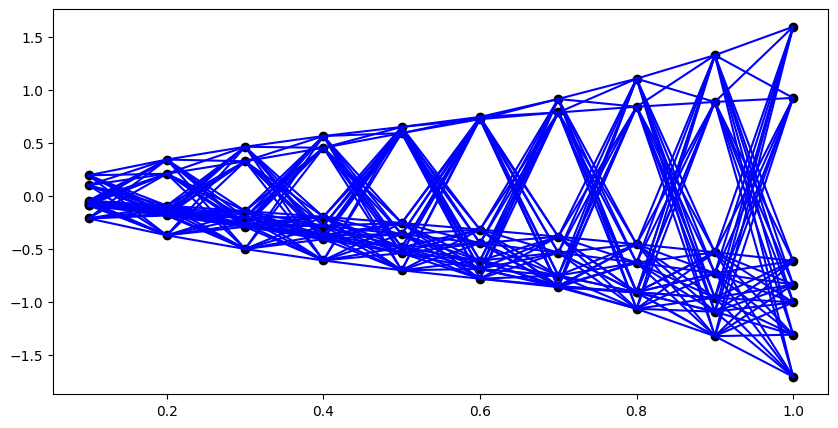

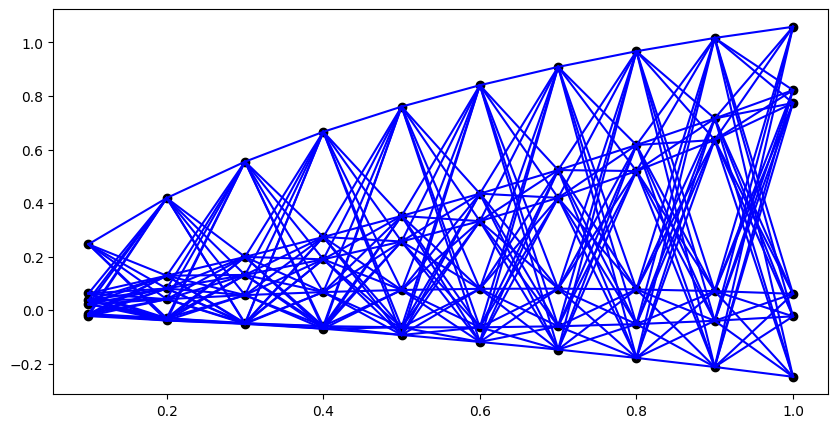

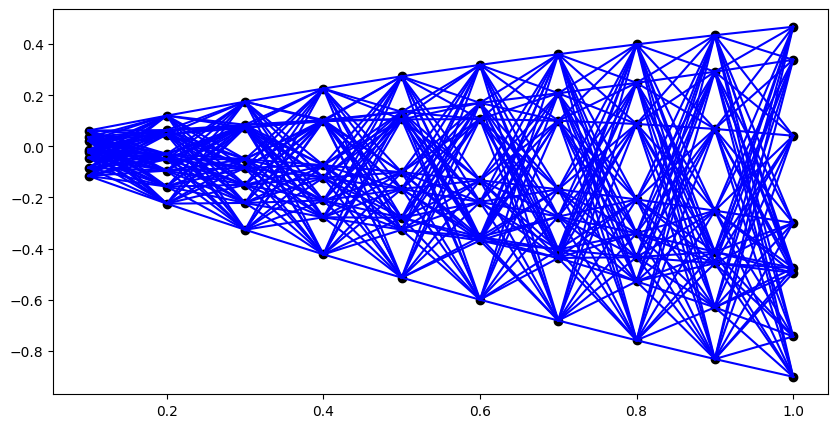

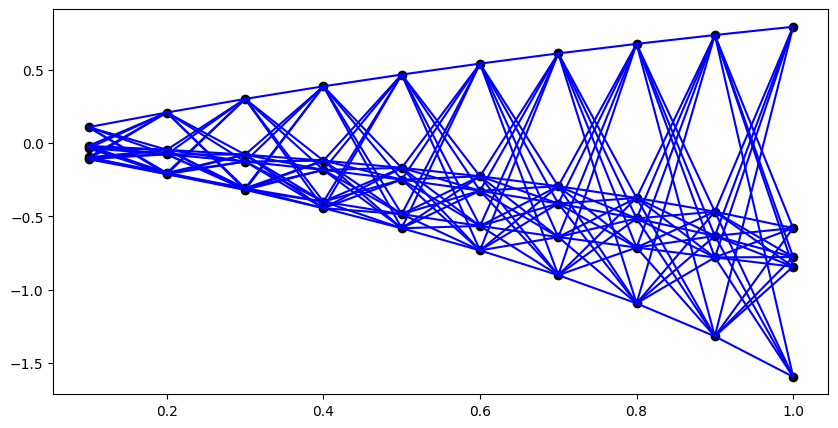

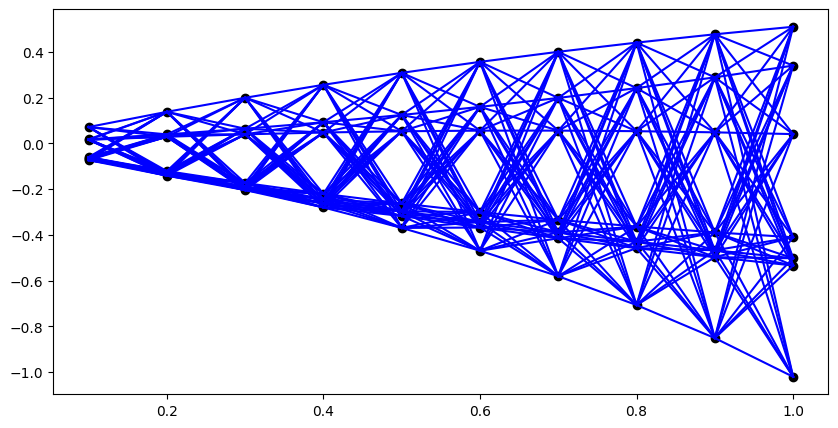

In [8]:
for i in range(5):
    plot_toy_graph(test_dataset[i])

The complexity of the graph depends on the angle cut we put on it. Try increasing max_angle to, say, `(5/6)*np.pi` and the graph should be more busy. The limit is of course `(6/6)*np.pi = pi` where each node will look at the full angle of available possible nodes to form an edge with. While playing with this number, run the next cell to see the proportion of fake edges to true edges (fake/true) on the above graph. This value will be extremely useful later.

In [9]:
#print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

## A Simple GNN

### Message Passing GNN

We can write out the full GNN as a class `MPNN_Network`. One can see its behaviour as:
1. Encode (x,y) features as hidden features with an N-layer MLP called `node_encoder`
2. Concatenate these along each edge, and feed the concatenated features into another MLP called `edge_network`
3. Sum the output of `edge_classifier` at each node (that is, each node receives the sum of the "messages" of all connecting edges). This sum is fed into `node_network`
4. Add the hidden features to the previous iteration (this helps to preserve information between messages)
5. Repeat (2) --> (4) n_graph_iters times
6. After the message passing loop, pass the features of each edge through an output classifier network called `edge_classifier`

In [10]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""
    hidden_activation = getattr(nn, hidden_activation)
    print("MWMW 1 ", output_activation)
    if output_activation is not None:
        if output_activation =='LogSoftmax':
            output_activation = nn.LogSoftmax
        else:    
            output_activation = getattr(nn, output_activation)
        print("MWMW 2 ", output_activation)

    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers
    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())
    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 3],
                                        #output_activation=None)
                                        output_activation='LogSoftmax')        

    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        x = self.node_encoder(data.x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        
        
        return self.edge_classifier(clf_inputs).squeeze(-1)

Build a version of the model and print it out.

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)
model

MWMW 1  ReLU
MWMW 2  <class 'torch.nn.modules.activation.ReLU'>
MWMW 1  ReLU
MWMW 2  <class 'torch.nn.modules.activation.ReLU'>
MWMW 1  ReLU
MWMW 2  <class 'torch.nn.modules.activation.ReLU'>
MWMW 1  LogSoftmax
MWMW 2  <class 'torch.nn.modules.activation.LogSoftmax'>


MPNN_Network(
  (node_encoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_feature

### Training on Toy Data

In [12]:
def train(model, train_loader, optimizer, weight):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)

        #loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        #loss = F.binary_cross_entropy(torch.sigmoid(pred.float()), torch.sigmoid(data.y.float()), weight=torch.tensor([weight]*len(data.y)).cuda())        
        loss = F.cross_entropy(pred.float(), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        #correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        correct += (pred.argmax(axis=1) == data.y.argmax(axis=1)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader, weight):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        #loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        #loss = F.binary_cross_entropy(torch.sigmoid(pred.float()), torch.sigmoid(data.y.float()), weight=torch.tensor([weight]*len(data.y)).cuda())
        loss = F.cross_entropy(pred.float(), data.y.float())
        total_loss += loss.item()
        #correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        correct += (pred.argmax(axis=1) == data.y.argmax(axis=1)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

In [13]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

We set a weight value that is more or less the (fake / true) ratio found above. This forces the loss function to punish incorrectly classified true edges more severely. It rebalances the distribution as if there was a 1:1 true:fake ratio.

### Important: 

try various numbers of epochs, to save time train with fewer epochs (let say 200)

### Exercise

You can use a static number of epochs, but to save time, you can also add a stop condition for the learning process.

Try to implement stopping after 10 epochs without improvement in the accuracy.

It is also a good practice to store the model, that returned the best values - usually it won't be the last one in the process of training.

In [14]:
%%time

epochs = 1000
weight = 2

m_configs = {"input_dim": 2, "hidden_node_dim": 16, "hidden_edge_dim": 16, "in_layers": 1, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 6, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0006, weight_decay=1e-3, amsgrad=True)

for epoch in range(epochs):
    ep += 1  
    model.train()
    acc, total_loss = train(model, train_loader, optimizer, weight)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    v_acc, v_total_loss = evaluate(model, test_loader, weight)
    v_loss_v.append(v_total_loss)
    v_acc_v.append(v_acc)

    print('Epoch: {}, Train accuracy: {:.4f}, val accuracy: {:.4f}, train loss: {:.4f}, val loss: {:.4f}'.format(ep, acc, v_acc, total_loss, v_total_loss))

MWMW 1  ReLU
MWMW 2  <class 'torch.nn.modules.activation.ReLU'>
MWMW 1  ReLU
MWMW 2  <class 'torch.nn.modules.activation.ReLU'>
MWMW 1  ReLU
MWMW 2  <class 'torch.nn.modules.activation.ReLU'>
MWMW 1  LogSoftmax
MWMW 2  <class 'torch.nn.modules.activation.LogSoftmax'>


/home/jupyter-mwolter/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 1, Train accuracy: 0.2901, val accuracy: 0.8500, train loss: 13.6264, val loss: 7.6681
Epoch: 2, Train accuracy: 0.8503, val accuracy: 0.8500, train loss: 7.0292, val loss: 6.2829
Epoch: 3, Train accuracy: 0.8503, val accuracy: 0.8500, train loss: 5.7770, val loss: 5.3746
Epoch: 4, Train accuracy: 0.8503, val accuracy: 0.8500, train loss: 5.3548, val loss: 5.3653
Epoch: 5, Train accuracy: 0.8503, val accuracy: 0.8500, train loss: 5.3280, val loss: 5.2929
Epoch: 6, Train accuracy: 0.8503, val accuracy: 0.8500, train loss: 5.2718, val loss: 5.2714
Epoch: 7, Train accuracy: 0.8503, val accuracy: 0.8500, train loss: 5.2700, val loss: 5.2729
Epoch: 8, Train accuracy: 0.8503, val accuracy: 0.8500, train loss: 5.2647, val loss: 5.2716
Epoch: 9, Train accuracy: 0.8503, val accuracy: 0.8500, train loss: 5.2570, val loss: 5.2696
Epoch: 10, Train accuracy: 0.8503, val accuracy: 0.8500, train loss: 5.2498, val loss: 5.2572
Epoch: 11, Train accuracy: 0.8503, val accuracy: 0.8500, train loss:

(0.9, 0.9782747051607054)

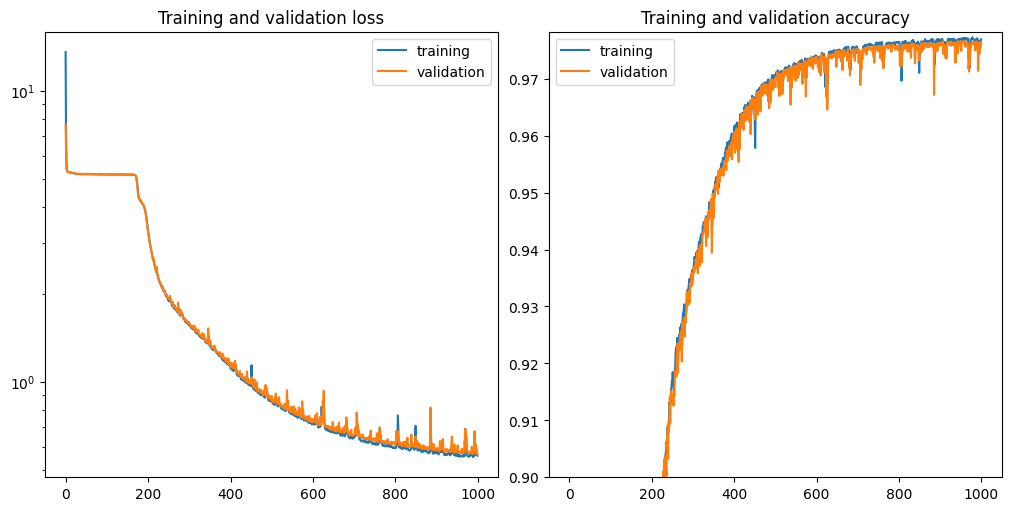

In [15]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, label="training")
axs[0].plot(np.arange(len(v_loss_v)), v_loss_v, label="validation")
axs[0].set_title("Training and validation loss")
axs[0].set_yscale("log")
axs[0].legend()
axs[1].plot(np.arange(len(t_acc_v)), t_acc_v, label="training")
axs[1].plot(np.arange(len(v_acc_v)), v_acc_v, label="validation")
axs[1].set_title("Training and validation accuracy")
axs[1].set_yscale("linear")
axs[1].legend()
axs[1].set_ylim([0.90, np.max(t_acc_v)+0.001])

### Did it work?

The best performance that I can get with some simple manual tuning is around 98% accuracy (for max_angle = 6/6*np.pi). We can improve the efficiency at the cost of purity by raising the weight on true edges, but the accuracy won't significantly improve. In general, the biggest changes were from increasing the width (i.e. the number of dimensions) of the hidden layers. We can visualise the performance on a particular graph, colouring true positives black, false positives red, true negatives a transparent black, and false negatives in blue.

In [16]:
def plot_toy_classified(event, preds, cut=0.5):
    
    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    plt.scatter(x, y, c='k')
    
    preds = preds.detach().numpy()
    
    for j in range(len(labels)):
        
        # False negatives
        #if preds[j,0] < cut and labels[j,0].item() > cut:
        if preds.argmax(axis=1)[j] == 0 and labels.argmax(axis=1)[j] > 0:    
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='b')

        # False positives
        #if preds[j,0] > cut and labels[j,0].item() < cut:
        if preds.argmax(axis=1)[j] > 0 and labels.argmax(axis=1)[j] == 0:    
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='r', alpha=np.clip(np.exp(preds[j,0]),0,1))

        # True positives
        if preds.argmax(axis=1)[j] == 1 and labels.argmax(axis=1)[j] == 1:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='green', alpha=np.clip(np.exp(preds[j,1]),0,1))
        if preds.argmax(axis=1)[j] == 2 and labels.argmax(axis=1)[j] == 2:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='orange', alpha=np.clip(np.exp(preds[j,2]),0,1))
            
        # True negatives
        if preds.argmax(axis=1)[j] == 0 and labels.argmax(axis=1)[j] == 0:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=1-np.clip(np.exp(preds[j,0]),0,1))

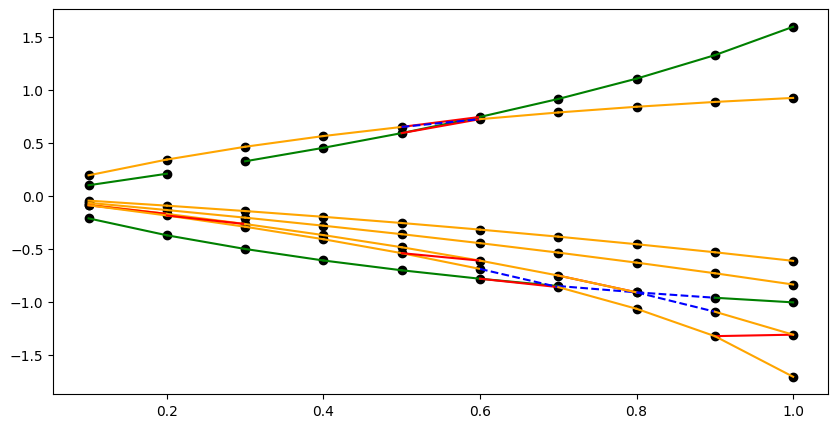

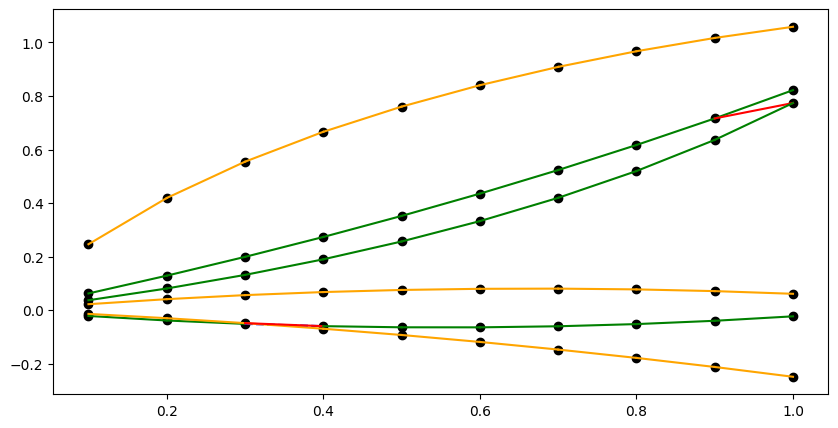

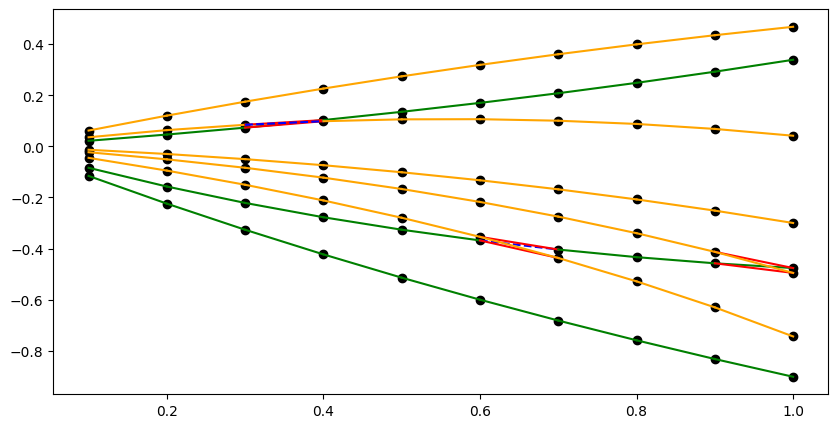

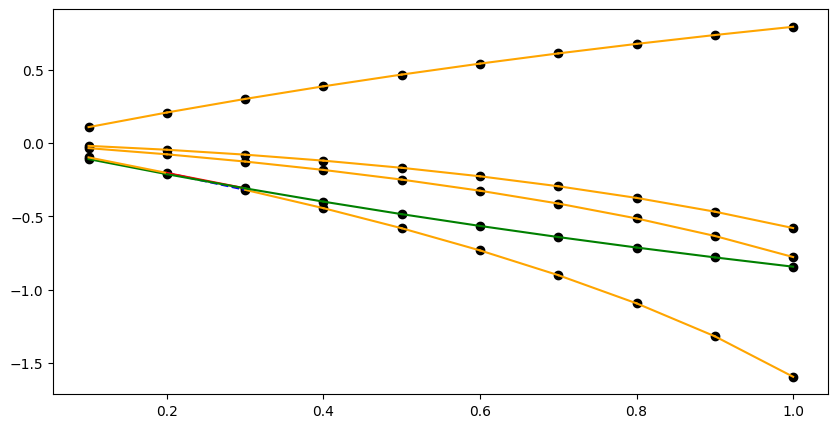

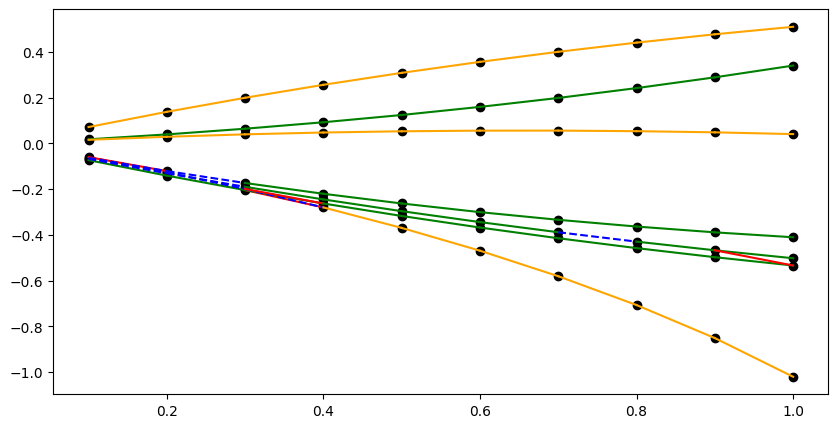

In [17]:
for i in range(5):
    data = test_loader.dataset[i].to(device)
    preds = torch.sigmoid(model(data)).to('cpu')
    plot_toy_classified(data.to('cpu'), preds, cut = 0.6)

So we can see that it's working quite well. Few missed true edges, and few misclassified fake edges. The ratio of false positives to false negatives (which can be defined with efficiency and purity) is controlled by the cut we put on the prediction score. 

### Plot the confussion matrix (for edges)

/home/jupyter-mwolter/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


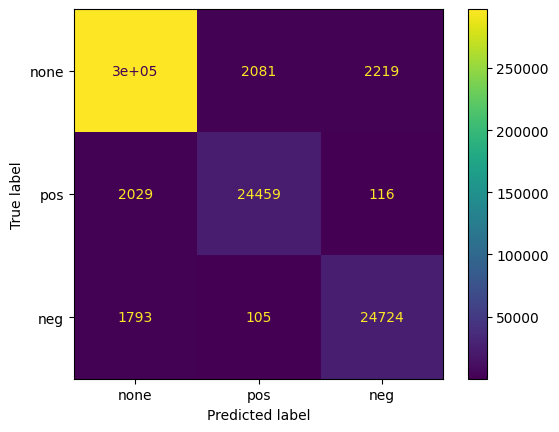

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
#from sklearn.metrics import RocCurveDisplay, roc_curve
#from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

y_test = torch.cat([data.y.cpu().argmax(axis=1) for data in test_loader.dataset])
y_pred = torch.cat([torch.sigmoid(model(data.to(device))).argmax(axis=1) for data in test_loader.dataset]).cpu()

display_labels = ['none','pos','neg']
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=display_labels).plot()

# **That's all**

In [19]:
print(data.y.cpu()[1:10])

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=torch.float64)


In [23]:
print((np.exp(model(data.to(device)).cpu().detach().numpy()))[0:10])

[[1.00000000e+00 0.00000000e+00 1.13332762e-34]
 [1.00000000e+00 0.00000000e+00 3.98986970e-30]
 [1.00000000e+00 0.00000000e+00 1.31003127e-28]
 [1.00000000e+00 1.26112515e-11 2.40497534e-32]
 [9.25983667e-01 6.40851283e-07 7.40157217e-02]
 [1.08550884e-01 7.93647408e-01 9.78017896e-02]
 [1.00000000e+00 0.00000000e+00 2.26586904e-31]
 [3.18496414e-02 9.54706728e-01 1.34436488e-02]
 [9.99041438e-01 9.58585471e-04 9.17422388e-12]
 [9.99958813e-01 4.11036417e-05 3.61014759e-15]]
